<center><font size="4"><span style="color:blue">Demonstration 4: example of early classification implementation</span></font></center>

This is a demonstration of the 3W dataset, the first realistic and public dataset with rare undesirable real events in oil wells as far as the authors of this work know. It can be used in development of several kinds of techniques and methods for different tasks associated with undesirable events in oil and gas wells.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering**.

**_Disclamer_**

_This notebook presents a demonstration. As we have not experienced all the possibilities, for example in terms of approaches, methods, parameter values, and metrics, we do not argue that the results presented here are optimal. However, these results can be used as initial benchmark for other works._

# 1. Introduction

This notebook presents an implementation of a specific task of interest (early classification) applied to the 3W dataset. In this task, classifications of observations of the transient or in regime periods of a type of undesirable event classified as being from the transient period of this type of undesirable event are considered to be anticipated. This type of classification is beneficial because it allows a longer time for actions to restore the normal state of the wells.

# 2. Imports and Configurations

In [1]:
import pandas as pd
import numpy as np
import logging
import warnings
import itertools
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_selection import select_features
from tsfresh.feature_extraction.settings import from_columns
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [2]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
data_path = Path('..', 'data')
nj = None
clfs = {'MLP' : MLPClassifier(random_state=1),
        'LDA' : LinearDiscriminantAnalysis(),
        'DT'  : DecisionTreeClassifier(random_state=1),
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class']
undesirable_events_codes = 2
normal_class_code = 0
abnormal_classes_codes = [2, 1]   # Undesirable events of interest
sample_size = 12*60               # In seconds = observations
max_samples_per_period = 20       # Limitation for safety
df_fc_p = MinimalFCParameters()   # See tsfresh's documentation
disable_progressbar = True        # Less output

# 3. Early Classification Implementation

The following cells implement a method for early classification. The more relevant choices of this method are:

1. Only real instances with certain types of undesirable events are used. The types of events that do not have transient period are not used;
1. The possible concept drift of normality is not considered. The used method supposes that normality and the undesirable events do not depend on time or specific well;
1. Before training and testing the classifiers, better features are selected with the help of the tsfresh package;
1. A specific sampling strategy is used for each type of period. In normal periods, the last observations are privileged. In periods in regime, it is sought to use observations throughout the regime as a whole. In normal periods, the first observations are privileged;
1. For each instance, the variables that remain frozen in the training samples are not used;
1. Before feature extraction the used variables are normalized with z-score;
1. For the sake of execution time, it is used the minimal set of features of the tsfresh package;
1. Three classifiers are evaluated (without parameters optimization).

In [5]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [6]:
def load_instance(instance_path):
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), 'invalid columns in the file {}: {}'\
            .format(str(instance_path), str(df.columns.tolist()))
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [7]:
def extract_samples(instance, class_code, df, df_samples, df_y, sample_id):
    # Gets the observations labels and their unequivocal set
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))
    
    # Discards the observations labels and replaces all nan with 0 
    # (tsfresh's requirement)
    df_vars = df.drop('class', axis=1).fillna(0)

    # Extracts samples from the normal period (if it exists)
    #
    if normal_class_code in set_ols:
        # Gets indexes (first and last) without overlap with other periods
        f_idx = ols.index(normal_class_code)
        l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size+1
        if (max_samples) > 0:  
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = sample_size
            step = min(step_wanted, step_max)

            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = l_idx-sample_size+1-(num_samples-1-idx)*step
                l_idx_c = f_idx_c+sample_size
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_sample.insert(loc=0, column='instance', value=instance)
                df_samples = df_samples.append(df_sample)
                df_y = df_y.append({'instance':instance, 
                                    'y':normal_class_code}, ignore_index=True)
                sample_id += 1

    # Extracts samples from the transient period (if it exists)
    #
    transient_code = class_code + 100
    if transient_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        

        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size+1
        if (max_samples) > 0:
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = np.inf
            step = min(step_wanted, step_max)

            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = f_idx+idx*step
                l_idx_c = f_idx_c+sample_size
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_sample.insert(loc=0, column='instance', value=instance)
                df_samples = df_samples.append(df_sample)
                df_y = df_y.append({'instance':instance, 
                                    'y':transient_code}, ignore_index=True)
                sample_id += 1
    
    # Extracts samples from the in regime period (if it exists)
    #
    if class_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # or end of this period
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
  
        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size+1
        if (max_samples) > 0 :
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = sample_size
            step = min(step_wanted, step_max)
    
            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = f_idx+idx*step
                l_idx_c = f_idx_c+sample_size
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_sample.insert(loc=0, column='instance', value=instance)
                df_samples = df_samples.append(df_sample)
                df_y = df_y.append({'instance':instance, 
                                    'y':class_code}, ignore_index=True)
                sample_id += 1
        
    return df_samples, df_y, sample_id

In [8]:
def show_cm(cm, clf_name, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(clf_name)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()
    plt.show()

In [9]:
def train_test_calc_cms(X_train, y_train, X_test, y_test, cms, clfs, labels):
    for clf_name, clf in clfs.items():
        try:
            # Train
            t0 = time()
            clf.fit(X_train, y_train)
            t_train = time() - t0
                
            # Test
            t0 = time()
            y_pred = clf.predict(X_test)
            t_test = time() - t0
           
            # Calculates and updates the confusion matrix
            cm = confusion_matrix(y_test, y_pred, labels=labels)
            cms[clf_name] += cm
            #show_cm(cm, clf_name, labels)
            
        except Exception as e:
            print('error in training/testing classifier: {}'.format(e))

    return cms

In [10]:
def loio(n):
    all_i = range(n)
    for i in all_i:
        test_i = set([i])
        train_i = set(all_i)-test_i
        yield train_i, test_i

In [11]:
# Gets all real instances but maintains only those with the specified undesirable event
instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
instances = instances.loc[instances.iloc[:, 0].isin(abnormal_classes_codes)].reset_index(drop=True)

In [12]:
# For each real instance with the specified undesirable event
df_samples = pd.DataFrame()
df_y = pd.DataFrame()
sample_id = 0
for i, row in instances.iterrows():
    class_code, instance_path = row
    
    # Load the current instance
    df = load_instance(instance_path)
        
    # Extracts samples from the current instance
    print('extracting samples from instance {}: {}...'.format(i+1, instance_path))    
    df_samples, df_y, sample_id = extract_samples(i, class_code, df, df_samples, df_y, sample_id)

extracting samples from instance 1: ../data/1/WELL-00001_20140124213136.csv...
extracting samples from instance 2: ../data/1/WELL-00002_20140126200050.csv...
extracting samples from instance 3: ../data/1/WELL-00006_20170801063614.csv...
extracting samples from instance 4: ../data/1/WELL-00006_20170802123000.csv...
extracting samples from instance 5: ../data/1/WELL-00006_20180618060245.csv...
extracting samples from instance 6: ../data/2/WELL-00002_20131104014101.csv...
extracting samples from instance 7: ../data/2/WELL-00003_20141122214325.csv...
extracting samples from instance 8: ../data/2/WELL-00003_20170728150240.csv...
extracting samples from instance 9: ../data/2/WELL-00003_20180206182917.csv...
extracting samples from instance 10: ../data/2/WELL-00009_20170313160804.csv...
extracting samples from instance 11: ../data/2/WELL-00010_20171218200131.csv...
extracting samples from instance 12: ../data/2/WELL-00011_20140515110134.csv...
extracting samples from instance 13: ../data/2/WE

In [13]:
# Initializes a confusion matrix for each classifier
labels = sorted(df_y['y'].unique().astype(int))
cms = {}
for clf_name, _ in clfs.items():
    cms[clf_name] = np.zeros([len(labels), len(labels)])
    
# For each round of a cross-validation with the 'leave one instance out' schema
for train_i, test_i in loio(len(instances)):
    print('testing/training instance: {}/{}'.format(test_i, train_i))
    
    # Checks if there is at least one testing sample
    if df_samples['instance'].isin(test_i).sum() < 1:
        print('no testing sample. round skipped')
        continue
    
    # Splits the samples and the labels
    df_samples_train = df_samples.loc[df_samples['instance'].isin(train_i)].reset_index(drop=True)
    df_samples_test  = df_samples.loc[df_samples['instance'].isin(test_i)].reset_index(drop=True)
    df_samples_train.drop(columns='instance', inplace=True, errors='ignore')
    df_samples_test.drop(columns='instance', inplace=True, errors='ignore')
    
    # Splits the labels
    y_train = np.array(df_y['y'][df_y['instance'].isin(train_i)])    
    y_test  = np.array(df_y['y'][df_y['instance'].isin(test_i)])   
    
    # Discards vars that are frozen in training samples
    frozen_vars = []
    good_vars = []
    for var in vars:
        if len(df_samples_train[var].unique()) == 1:
            frozen_vars.append(var)
        else:
            good_vars.append(var)
    df_samples_train.drop(columns=frozen_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=frozen_vars, inplace=True, errors='ignore')    
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[good_vars] = scaler.fit_transform(df_samples_train[good_vars])
    df_samples_test[good_vars] = scaler.transform(df_samples_test[good_vars])    

    # Extracts and selects features from samples
    X_train = extract_features(df_samples_train, 
                               column_id='id', 
                               column_sort='timestamp', 
                               default_fc_parameters=df_fc_p,
                               impute_function=impute,
                               n_jobs=0,
                               disable_progressbar=disable_progressbar)
    X_train = X_train.reset_index(drop=True)
    X_train_sel = select_features(X_train, 
                                  y_train, 
                                  ml_task='classification',
                                  n_jobs=0)
    X_train_sel = X_train_sel.reset_index(drop=True)    
    kfcp = from_columns(X_train_sel)
    X_test_sel = extract_features(df_samples_test, 
                                  column_id='id', 
                                  column_sort='timestamp',
                                  default_fc_parameters={},
                                  kind_to_fc_parameters=kfcp,
                                  impute_function=impute,
                                  n_jobs=0,
                                  disable_progressbar=disable_progressbar)    
    X_test_sel = X_test_sel.reset_index(drop=True)
    
    # Trains, tests and calculates the confusion matrices
    cms = train_test_calc_cms(X_train_sel, y_train, X_test_sel, y_test, cms, clfs, labels) 

testing/training instance: {0}/{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
testing/training instance: {1}/{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
testing/training instance: {2}/{0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
testing/training instance: {3}/{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
testing/training instance: {4}/{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
testing/training instance: {5}/{0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
testing/training instance: {6}/{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
testing/training instance: {7}/{0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 

# 4. Results

The results obtained with the implemented method are presented in this section.

In [14]:
print('used features: {}'.format(list(df_fc_p.keys())))

used features: ['sum_values', 'median', 'mean', 'length', 'standard_deviation', 'variance', 'maximum', 'minimum']


Besides the used features, three metrics are calculated for each evaluated classifier and the results are presented in the following subsections:

- *Overall Accuracy*: the overall accuracy without distinction between each transient period and its corresponding in regime period;
- *Hit Rate*: the hit rate of a type of undesirable event without distinction between its transient and in regime periods. In other words, the fraction of all observations of the **transient or in regime periods** of a type of undesirable event classified as being from the **transient or in regime periods** of this type of undesirable event;
- *Anticipation Rate*: the fraction of all observations of the **transient or in regime periods** of a type of undesirable event classified as being from the **transient period** of this type of undesirable event.

# 4.1. Overall Accuracy

For each evaluated classifier, the confusion matrix is adapted with grouping of the corresponding transient and in regime periods. And then the metric is calculated and presented in the following table.

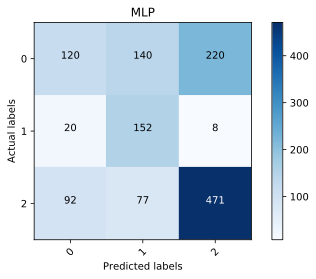

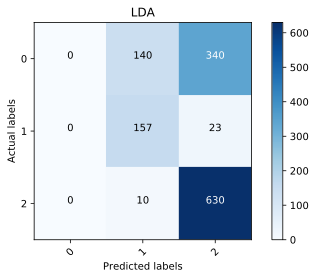

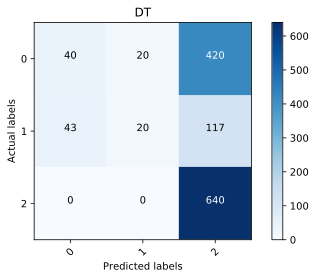

In [15]:
oaccs = pd.DataFrame(columns=['CLASSIFIER', 'OVERALL ACCURACY'])
new_labels = labels.copy()
for clf in clfs:
    cm = cms[clf]
    new_cm = cm.copy()
    i_del = []
    for l in [lt for lt in labels if lt > 100]:
        i_trans, i_in_reg = labels.index(l), labels.index(l-100)
        i_del.append(i_trans)
        new_cm[i_in_reg, :] += new_cm[i_trans, :]
        new_cm[:, i_in_reg] += new_cm[:, i_trans]
    new_cm = np.delete(new_cm, i_del, axis=0)
    new_cm = np.delete(new_cm, i_del, axis=1)
    new_labels = np.delete(new_labels, i_del, axis=0)
    show_cm(new_cm, clf, new_labels)
    oacc = np.trace(new_cm)/new_cm.sum()
    oaccs = oaccs.append({'CLASSIFIER': clf, 'OVERALL ACCURACY': oacc}, ignore_index=True)

In [16]:
oaccs.set_index('CLASSIFIER').sort_values(by=['OVERALL ACCURACY'], ascending=False)

,OVERALL ACCURACY
CLASSIFIER,
LDA,0.605385
MLP,0.571538
DT,0.538462


# 4.2. Hit Rate and Anticipation Rate

It can be observed that both rates are more favorable for the type of event 2. One factor that supports this result is the 'sample_size' parameter. According to specialists, the type of event 1 has a slower dynamics compared to the type of event 2. Therefore, the used sample size was more appropriate to capture discriminatory characteristics of the type of event 2.

In [17]:
ars = pd.DataFrame(columns=['TYPE OF EVENT', 'CLASSIFIER', 'HIT RATE', 'ANTICIPATION RATE'])
for clf in clfs:
    cm = cms[clf]
    for acc in abnormal_classes_codes:
        if (acc+100) in labels:
            i_trans, i_in_reg = labels.index(acc+100), labels.index(acc)
            all_trans_or_in_reg = cm[[i_trans, i_in_reg], :].sum()
            clsed_as_trans_or_in_reg = cm[i_trans,  [i_trans, i_in_reg]].sum() + \
                                       cm[i_in_reg, [i_trans, i_in_reg]].sum()
            clsed_as_trans = cm[[i_trans, i_in_reg], i_trans].sum()
            hr = clsed_as_trans_or_in_reg/all_trans_or_in_reg
            ar = clsed_as_trans/all_trans_or_in_reg
            ars = ars.append({'TYPE OF EVENT':acc, 
                              'CLASSIFIER': clf, 
                              'HIT RATE': hr,
                              'ANTICIPATION RATE': ar},
                            ignore_index=True)
ars.set_index('TYPE OF EVENT').sort_values(by=['TYPE OF EVENT', 'HIT RATE', 'ANTICIPATION RATE'], ascending=False)

,CLASSIFIER,HIT RATE,ANTICIPATION RATE
TYPE OF EVENT,,,
2,DT,1.000000,1.000000
2,LDA,0.984375,0.921875
2,MLP,0.735938,0.718750
1,LDA,0.872222,0.872222
1,MLP,0.844444,0.844444
1,DT,0.111111,0.111111
